In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from functions import *

In [2]:
os.getcwd()

'c:\\Users\\USER\\Desktop\\컴퓨터비전개론\\Excercise1'

In [3]:
img = cv2.imread("Sample Images/shapes.png", cv2.IMREAD_GRAYSCALE)

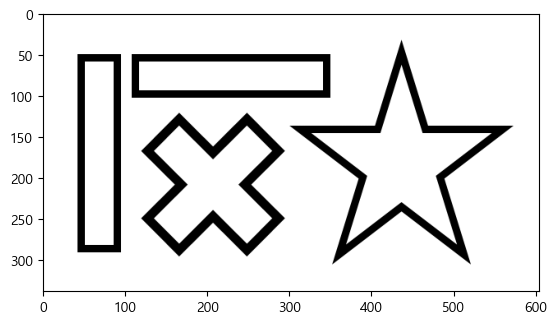

In [5]:
plt.imshow(img, cmap="gray")
plt.show()

#### Part2. Edge Detection

2-1. Apply the Gaussian filtering to the input image.

In [12]:
# a) You need to use functions implemented in Part #1.
# b) The Gaussian filter (7, 1.5) is utilized to produce the following examplar results.

kernel = get_gaussian_filter_2d(size=7, sigma=1.5)
filtered_img = cross_correlation_2d(img, kernel=kernel)

2-2. Implement a function that returns the image gradient by referring the lecture slide

In [8]:
def compute_image_gradient(img):

    # (a) First apply the Sobel filters to compute derivatives along x and y directions
    sobel_x = np.array([[1,0,-1], [2,0,-2], [1,0,-1]])
    sobel_y = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])

    # image에 Sobel_x, Sobel_y를 적용한 결과의 집합은 gradient (gradient = [sobel_x*f, sobel_y*f])
    # a) First apply the Sobel filters to compute derivatives along x and y directions
    grad_x = cross_correlation_2d(img, kernel=sobel_x)
    grad_y = cross_correlation_2d(img, kernel=sobel_y)

    # b) For each pixel, compute magnitude and direction of gradient.
    # direction
    dir = np.rad2deg(np.arctan2(grad_y, grad_x)) + 180

    # magnitude
    mag = ((grad_x**2)+(grad_y**2))**(1/2)

    return (mag, dir)

In [13]:
mag, dir = compute_image_gradient(filtered_img)

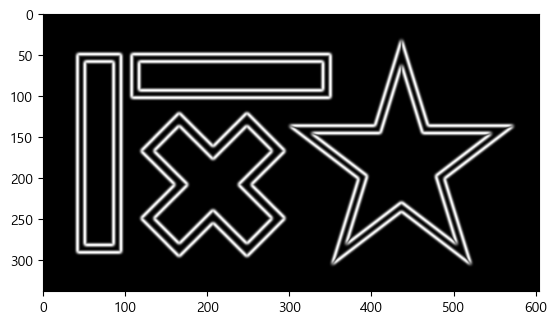

In [14]:
plt.imshow(mag, cmap="gray")
plt.show()

2-3. Implement a function that performs Non-maximum Suppression (NMS):

In [11]:
def non_maximum_suppression_dir(mag, dir):
    suppressed_mag = mag.copy()
    # c) For  instance,  if  the  gradient  direction  is   145°  then  it  is  quantized to   135°.  In  this  case,  the  
    # magnitude at the center position in the window should be compared to the north-west and south-
    # east positions as illustrated in the figure below.

    for i in range(1, mag.shape[0]-1):
        for j in range(1, mag.shape[1]-1):
            deg = dir[i][j]
            if (deg < 22.5) or (157.5 <= deg < 202.5) or (337.5 < deg):
                if mag[i][j] <= mag[i][j+1] or mag[i][j] < mag[i][j-1]:
                    suppressed_mag[i][j] = 0
            elif (22.5 <= deg < 67.5) or (202.5 <= deg < 247.5):
                if mag[i][j] < mag[i-1][j-1] or mag[i][j] <= mag[i+1][j+1]:
                    suppressed_mag[i][j] = 0
            elif (67.5 <= deg < 112.5) or (247.5 <= deg < 292.5):
                if mag[i][j] < mag[i-1][j] or mag[i][j] <= mag[i+1][j]:
                    suppressed_mag[i][j] = 0
            elif (112.5 <= deg < 157.5) or (292.5 <= deg < 337.5):
                if mag[i][j] <= mag[i-1][j+1] or mag[i][j] < mag[i+1][j-1]:
                    suppressed_mag[i][j] = 0
    return suppressed_mag 

In [15]:
suppressed = non_maximum_suppression_dir(mag, dir)

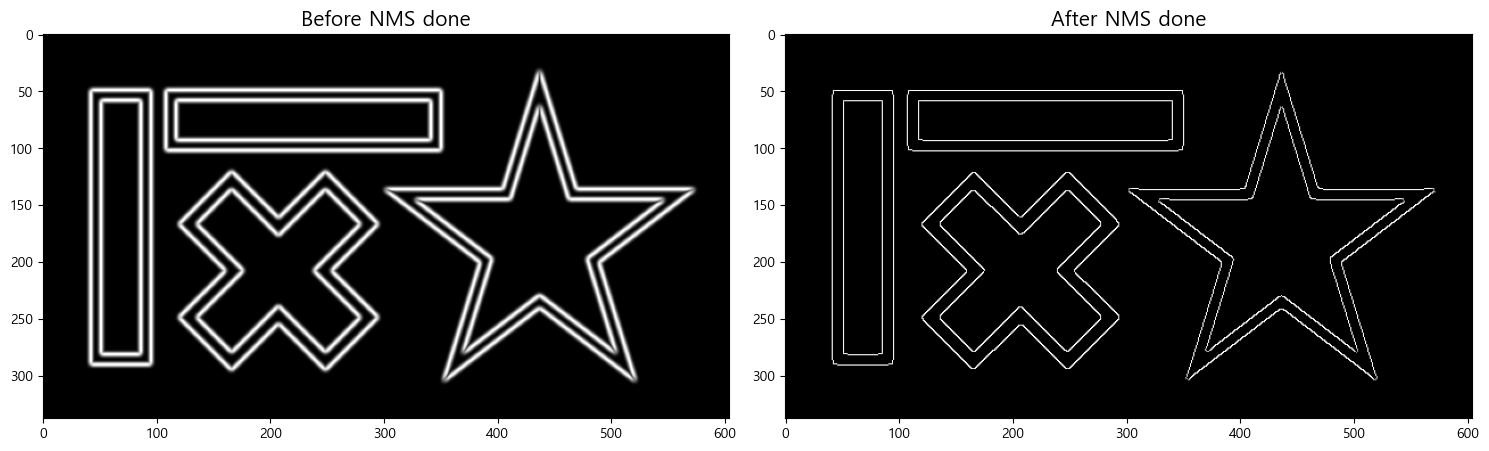

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))
ax[0].imshow(mag, cmap="gray")
ax[0].set_title("Before NMS done", size=15)

ax[1].imshow(suppressed, cmap="gray")
ax[1].set_title("After NMS done", size=15)

plt.tight_layout()
plt.show()